In [1]:
import sys
sys.path.append("../")

import cv2
import torch
import torchvision.transforms as T
from sklearn.manifold import MDS
import webdataset as wds


from online_byol import SamplingWorldModel 
from train_byol import ImpalaEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
encoder = SamplingWorldModel(ImpalaEncoder(1, stack_sz=1, grp_norm=0))
encoder = encoder.load_checkpoint_("../results/2022Nov28-141753_BYOL_w16/0001_dynamics_net.args_.K_4/0/model_01320000.pkl")

In [3]:
prep = T.Lambda(
    lambda x: cv2.resize(
        cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), (96, 96), interpolation=cv2.INTER_AREA
    )
)

In [4]:
dset = (
    wds.WebDataset("../data/MDQN_rgb/Enduro/1/50000000.tar", shardshuffle=True)
    .decode("rgb8")
    .to_tuple("state.png", "ard.msg", "__key__")
    .map_tuple(prep, None, None)
)

In [5]:
features = []
encoder.reset(device=torch.device("cpu"))

for i, (obs, ard, _) in enumerate(dset):
    
    obs = torch.from_numpy(obs).view(1,1, 1, 96, 96)
    with torch.no_grad():
        features.append(encoder(obs).detach())
    
    if ard["done"]:
        print("done", i)
        break

features = torch.cat(features).squeeze()

done 23295


In [7]:
embedding = MDS(n_components=2)
Z = embedding.fit_transform(features[:3000])

df = pd.DataFrame(data=Z, columns=["c0", "c1"])
df["t"] = [i for i in range(Z.shape[0])]

<AxesSubplot: xlabel='c0', ylabel='c1'>

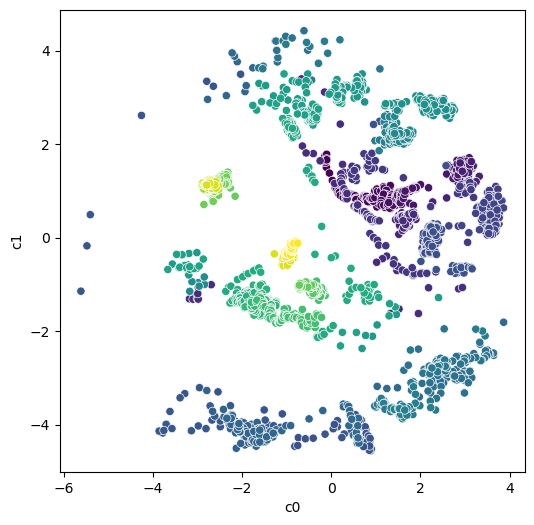

In [8]:
f = plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x="c0", y="c1", hue="t", legend=False, palette="viridis")

<AxesSubplot: xlabel='c0', ylabel='c1'>

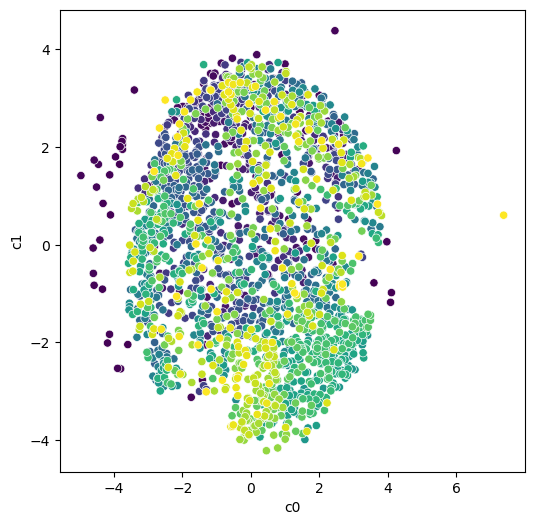

In [58]:
### breakout

<AxesSubplot: xlabel='c0', ylabel='c1'>

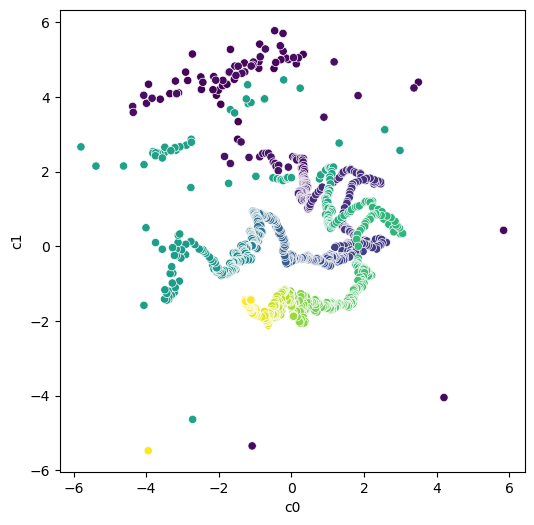

In [54]:
# ms pacma

RangeIndex(start=0, stop=2053, step=1)